# Predicting US Mining Accidents

The goal of this project is to predict the frequency of mining-relateda accidents in the United States. Raw data were obtained in txt files from the **Mine Safety and Health Administration (MSHA)**, which is under the US Department of Labor. Accidents occurrences are given from 2000 to 2017.

### Project steps
1. Import the data
2. Aggregate and explore data
    * What is the overall trend in accidents from 2000 to 2017?
    * When and where are accidents more likely, and under what conditions?
3. Feature engineering / data preparation
4. Build predictive model, generate insights
    * What are the strongest predictors of accidents?
    
### 1. Data Import

First, the data were downloaded from three tab-separated `txt` files all found at https://arlweb.msha.gov/OpenGovernmentData/OGIMSHA.asp:
1. `Employment/Production Data Set (Quarterly)`: Textfile of quarterly mine production and employment beginning in 2000 (171.8 Mb)
2. `Mines Data Set`: Textfile of information about the location and status of all mines in the US (34.4 Mb)
3. `Accident Injuries Data Set`: Textfile of information about each individual accident beginning in 2000 (174.4 Mb)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

prod = pd.read_table('MinesProdQuarterly.txt', sep='|', encoding='ISO-8859-1')
accs = pd.read_table('Accidents.txt', sep='|', encoding='ISO-8859-1')
mines = pd.read_table('Mines.txt', sep='|', encoding='ISO-8859-1')

In [7]:
prod[:5]

,MINE_ID,CURR_MINE_NM,STATE,SUBUNIT_CD,SUBUNIT,CAL_YR,CAL_QTR,FISCAL_YR,FISCAL_QTR,AVG_EMPLOYEE_CNT,HOURS_WORKED,COAL_PRODUCTION,COAL_METAL_IND
0,1202098,Pond Creek Mine,IN,99,OFFICE WORKERS AT MINE SITE,2000,1,2000,2,1,160,NaN,C
1,1202127,Columbia Mine,IN,30,MILL OPERATION/PREPARATION PLANT,2000,3,2000,4,8,4989,NaN,C
2,1516576,KELLIOKA 5,KY,2,SURFACE AT UNDERGROUND,2000,2,2000,3,0,0,NaN,C
3,1516577,Mill Creek Prep Plant,KY,99,OFFICE WORKERS AT MINE SITE,2000,4,2001,1,1,603,NaN,C
4,1516599,Burnwell Energy,KY,1,UNDERGROUND,2000,1,2000,2,27,16520,136202.0,C


In [8]:
accs[:3]

,MINE_ID,CONTROLLER_ID,CONTROLLER_NAME,OPERATOR_ID,OPERATOR_NAME,CONTRACTOR_ID,DOCUMENT_NO,SUBUNIT_CD,SUBUNIT,ACCIDENT_DT,...,DAYS_RESTRICT,DAYS_LOST,TRANS_TERM,RETURN_TO_WORK_DT,IMMED_NOTIFY_CD,IMMED_NOTIFY,INVEST_BEGIN_DT,NARRATIVE,CLOSED_DOC_NO,COAL_METAL_IND
0,100003,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",B5225,220171080013,3,"STRIP, QUARY, OPEN PIT",04/12/2017,...,0.0,0.0,N,04/13/2017,?,NO VALUE FOUND,NaN,Driver was disconnecting unload hose from pump...,NaN,M
1,100003,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",NaN,220032180028,30,MILL OPERATION/PREPARATION PLANT,07/26/2003,...,NaN,NaN,N,07/28/2003,13,NOT MARKED,NaN,USING DRILL PRESS IN SHOP TO DRILL HOLES IN A ...,NaN,M
2,100011,M11763,Imerys S A,L17074,Imerys Pigments LLC,NaN,220001710004,30,MILL OPERATION/PREPARATION PLANT,04/26/2000,...,1.0,NaN,N,04/28/2000,13,NOT MARKED,NaN,EE WAS NOT WATCHING WHERE HE WAS WALKING AND S...,3.200017e+11,M


In [9]:
mines[:3]

,MINE_ID,CURRENT_MINE_NAME,COAL_METAL_IND,CURRENT_MINE_TYPE,CURRENT_MINE_STATUS,CURRENT_STATUS_DT,CURRENT_CONTROLLER_ID,CURRENT_CONTROLLER_NAME,CURRENT_OPERATOR_ID,CURRENT_OPERATOR_NAME,...,NO_NONPRODUCING_PITS,NO_TAILING_PONDS,PILLAR_RECOVERY_USED,HIGHWALL_MINER_USED,MULTIPLE_PITS,MINERS_REP_IND,SAFETY_COMMITTEE_IND,MILES_FROM_OFFICE,DIRECTIONS_TO_MINE,NEAREST_TOWN
0,100003,O'Neal Quarry & Mill,M,Surface,Active,01/22/1979,0041044,Lhoist Group,L13586,Lhoist North America,...,NaN,0.0,N,N,N,N,N,100,Approx 7 miles south of the city of Alabaster ...,Calera
1,100004,Brierfield Quarry,M,Surface,Active,03/04/2003,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",...,NaN,0.0,N,N,N,N,N,35,"I-65 SOUTH EXIT US 31 TO CALERA, TURN RIGHT ON...",Brierfield
2,100005,Birmingham Plant,M,Surface,Abandoned,08/15/1989,0041044,Lhoist Group,L10998,Allied Lime Company,...,NaN,NaN,N,N,N,N,N,0,NaN,NaN


Because each row of the accidents data corresponds to a single accident, if we want to predict the *frequency* of accidents over any given period of time, then we need to aggregate the data by that unit of time. For exploratory purposes, we will aggregate accident counts over days.

In [38]:
#transform date columns
accs['ACCIDENT_DT'] = pd.to_datetime(accs['ACCIDENT_DT'], format='%m/%d/%Y')
accs['RETURN_TO_WORK_DT'] = pd.to_datetime(accs['RETURN_TO_WORK_DT'], format='%m/%d/%Y')

#aggregate by date. apd: Accs Per Day
apd = accs.groupby(['ACCIDENT_DT'])
#.reset_index() is important to make sure the result returned is a data.frame
apd = apd.size().reset_index(name='count').sort_values(by='ACCIDENT_DT')
apd[:6]

,ACCIDENT_DT,count
0,2000-01-01,5
1,2000-01-02,12
2,2000-01-03,79
3,2000-01-04,62
4,2000-01-05,55
5,2000-01-06,49


In [11]:
apd.shape

(6525, 2)

### 2. Data Aggregation and Exploration

Text(0.5,0,'Date')

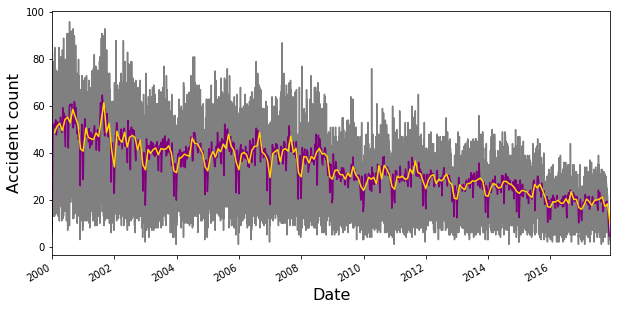

In [69]:
#plot data inline as a timeseries
%matplotlib inline
apd_2 = pd.Series(apd['count'].values, index=apd['ACCIDENT_DT'])
apd_2.plot(figsize=(10,5), color='gray')

#add weekly and monthly averages
apd_2.resample('W').mean().plot(color='purple')
apd_2.resample('M').mean().plot(color='gold')
plt.ylabel('Accident count', fontsize=16)
plt.xlabel('Date', fontsize=16)

This plot shows that accidents have consistently decreased from 2000 to 2016 with a concomitant decrease in variability. However, there's a lot of noise, making it hard to see any monthly or seasonal trends. It will be worth aggregating the data across a larger timescale (make it less granular) in order to track any of these potential patterns better. The purple and white lines are weekly and monthly averages, respectively.

With these we can see that accidents peak in the summer and floor in the winter with some noise about this pattern. Besides seasonal trends, we can more clearly see the overall downwards trend from 2000. It may thus be useful to account for these patterns by decomposing the series into trend and seasonal aspects and try to model the remainder (error).

Text(0.5,0,'Date')

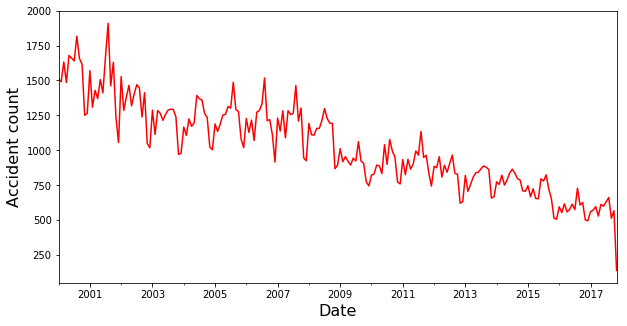

In [49]:
#aggregate by month with the resample method
%matplotlib inline

apm = apd_2.resample('M').sum().plot(figsize=(10,5), color='r')
plt.ylabel('Accident count', fontsize=16)
plt.xlabel('Date', fontsize=16)

If we wanted to predict the number of accidents on any given day, we want to understand the effect of the day of the week.

In [82]:
accs['ACCIDENT_WKDAY'] = accs['ACCIDENT_DT'].dt.weekday_name
apwkday = accs.groupby(['ACCIDENT_WKDAY'])\
    .size().reset_index(name='count').sort_values(by='count', ascending=False)

apwkday

,ACCIDENT_WKDAY,count
1,Monday,41837
5,Tuesday,41078
6,Wednesday,39783
4,Thursday,38017
0,Friday,33484
2,Saturday,17138
3,Sunday,10214


It looks like accidents are highest on Monday and decrease throughout the week with a sharp decline during the weekend (when presumably less people are working). Another thing to look at is the proportion of accidents attributed to each state, coal vs. metal factor, mine subunit (mine vs. office etc.), mine type (surface vs. underground). Look for a way to do this in python using plotting. 

It may also be useful to extract information about the type of the accident from the narrative.